# [EX_03] 고양이 수염 스티커 만들기

## Step 1. 스티커 구하기 or 만들기

* flaction 사이트에서 고양이 수염 사진 다운로드
* cloud jupyter를 이용하여 고양이 수염 사진 업로드

#### \# 필요한 라이브러리 import 하기

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

#### \# cloud jupyter 이용하여 고양이 수염 사진 업로드하고 불러오기

In [3]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_nose.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
print (img_sticker.shape)

(512, 512, 3)


## Step 2. 얼굴 검출 & 랜드마크 검출 하기

#### \# 셀카 업로드하고 불러오기

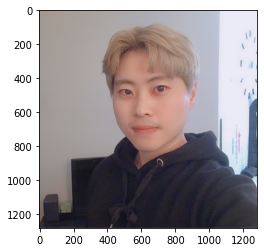

In [41]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/selfie_0.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_rgb)
plt.show()

#### \# dlib를 이용하여 얼굴 bounding box를 찾는다.

In [42]:
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)
print(dlib_rects)

rectangles[[(399, 348) (861, 811)]]


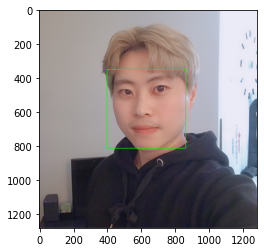

In [43]:
# 위에서 찾은 얼굴 bounding box를 출력
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#### \# 얼굴 bounding box 내에서 landmark를 찾는다.

In [44]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [45]:
# 찾은 landmark들의 좌표를 리스트 형식으로 저장

list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


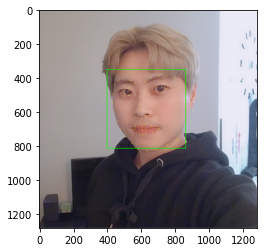

In [46]:
# 찾은 landmark 출력
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## Step 3. 스티커 적용 위치 확인하기

#### \# 고양이 수염이 적용될 위치를 계산하기 위해 고양이 수염 이미지부터 불러오기

In [47]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_nose.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
#img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(512, 512, 3)


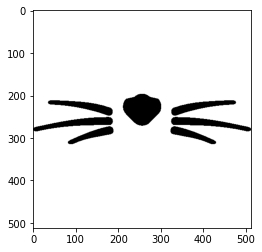

In [48]:
# 고양이 수염 사진 출력
plt.imshow(cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB))
plt.show()

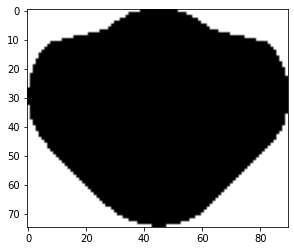

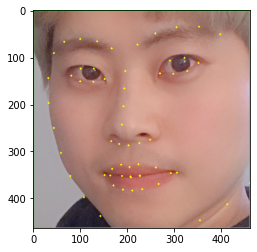

In [49]:
# 고양이 수염 사진에서 코 부분만 확대
plt.imshow(cv2.cvtColor(img_sticker[197:272, 211:301], cv2.COLOR_BGR2RGB))
plt.show()

# top: 197
# bottom: 271 (뒤에 넣어야 하니 272)
# left: 211
# right:300 (뒤에 넣어야하니 301)
# 코중심: [226, 256]
# 코중심에서 코끝까지 길이 46

plt.imshow(cv2.cvtColor(img_show[dlib_rects[0].top(): dlib_rects[0].bottom(), dlib_rects[0].left():dlib_rects[0].right()], cv2.COLOR_BGR2RGB))
plt.show()



콧등인 30번을 고양이 코의 중심 좌표로 설정.
코끝인 33번을 고양이 코 아래끝으로 설정 

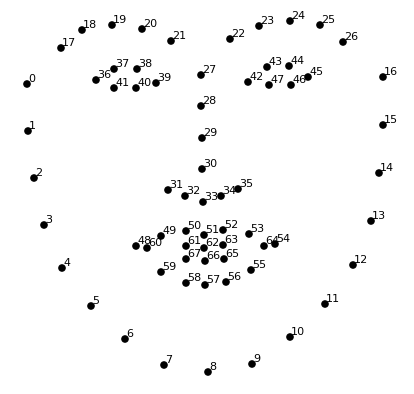

In [50]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x, y = landmark[30]
    ratio = (landmark[33][1] - landmark[30][1]) / 46
    print ('(x,y) : (%d,%d)'%(x,y))
    print('face / cat: {}'.format(ratio))

print("sticker image shape: {}".format(img_sticker[197:315, :].shape))    
img_stic = cv2.resize(img_sticker[197:315, :], (0, 0), fx=ratio, fy=ratio) # 고양이 수염 사진의 위 아래 여백을 자름
print("rehaped sticker image shape: {}".format(img_stic.shape))

(588, 591)
(x,y) : (588,591)
face / cat: 0.9565217391304348
sticker image shape: (118, 512, 3)
rehaped sticker image shape: (113, 490, 3)


In [51]:
refined_x = x - img_stic.shape[1]//2
refined_y = int(y - 30*ratio)
print("top left point: ({}, {})".format(refined_x, refined_y))

top left point: (343, 562)


In [52]:
#수염의 범위가 인덱스를 벗어나는 것을 방지
if refined_x < 0:
    img_stic = img_stic[:, -refined_x:]
    refined_x = 0

# 왼쪽 뿐 아니라 오른쪽으로도 벗어날 수 있음
if refined_x + img_stic.shape[1] > img_bgr.shape[1]:
    img_stic = img_stic[:, :refine_x + img_stic.shape[1] - img_bgr.shape[1]]
if refined_y < 0:
    img_stic =img_stic[-refiend_y:0, :]
    refiend_y = 0
    
# 위 뿐 아니라 아래쪽으로도 벗어날 수 있음
if refined_y + img_stic.shape[0] > img_bgr.shape[0]:
    img_stic = img_stic[:refine_y + img_stic.shape[0] - img_bgr.shape[0], :]

## Step 4. 스티커 적용하기

In [53]:
sticker_area = img_bgr[refined_y:refined_y+img_stic.shape[0], refined_x:refined_x+img_stic.shape[1]]
img_result =img_bgr.copy()
#img_result[refined_y:refined_y+img_stic.shape[0], refined_x:refined_x+img_stic.shape[1]] = \
#    np.where(img_stic==0,img_stic, sticker_area).astype(np.uint8)

# addWeighted 함수를 이용하여 수염 이미지의 투명도를 조절해준다
# 예제와는 다르게 수염의 값이 0이므로 np.where 함수의 인자 순서를 반대로 해줘야 한다 
img_result_ = \
    cv2.addWeighted(np.where(img_stic==0,img_stic, sticker_area).astype(np.uint8), 0.6, \
                    img_result[refined_y:refined_y+img_stic.shape[0], refined_x:refined_x+img_stic.shape[1]], 0.4, 0)

img_result[refined_y:refined_y+img_stic.shape[0], refined_x:refined_x+img_stic.shape[1]] = img_result_


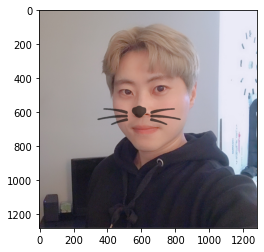

In [55]:
# 출력
plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
plt.show()

## Step 5. 문제점 찾아보기

1. 자기만의 카메라앱 기능 구현을 완수하였다.  
 - 원본에 스티커 사진이 정상적으로 합성되었다.
2. 스티커 이미지를 정확한 원본 위치에 반영하였다.  
 - 정확한 좌표계산을 통해 고양이 수염의 위치가 원본 얼굴에 잘 어울리게 출력되었다.
3. 카메라 스티커앱을 다양한 원본이미지에 적용했을 때의 문제점을 체계적으로 분석하였다.  
 - 얼굴각도, 이미지 밝기, 촬영거리 등 다양한 변수에 따른 영향도를 보고서에 체계적으로 분석하였다.


\#. 얼굴의 각도가 달라져도 고양이 수염은 회전하지 않고 그대로 적용되는 문제 발생

![image.png](https://github.com/superbJeong/Exploration/blob/main/adding1.png?raw=true)

위의 결과와 같이 콧등에 맞게 위치는 잘 했지만 얼굴의 기울기를 고려하지 않아 어색한 모습이 나타남

\#. 앞모습이 아닌 대각선측면의 경우 얼굴 바운딩박스 밖에도 랜드마크 포인트가 존재

![image.png](https://github.com/superbJeong/Exploration/blob/main/adding2.png?raw=true)

이와 같은 경우 단순 기울기 뿐 아니라 정면에서 얼마만큼 측면으로 돌아가 있는지 확인이 어려울 수 있다.  
만약 사진 중간이 아닌 가장자리라면 랜드마크가 아예 생성되지 못할 것이므로 구동자체가 안될 가능성이 있음.

\#. 실험은 못해봤지만 흰 바탕에 너무 높은 조도의 환경에서 촬영하면 얼굴 윤곽이 사라져 랜드마크 예측이 제대로 되지 않을 것으로 생각함

# 회고

1. 이미지를 다뤄본 경험이 있어서 픽셀값을 다루는 것이 조금은 익숙했다.  
다만, 파이썬으로 이미지를 다루는 pyplot을 이용해서 시각화하는 부분이나  
cv2를 이용해 이미지를 변화시키는 방법들에 대해 숙달되는것이 필요한 것 같다

2. 수염의 위치를 정하는 과정에서 콧등과 코아래부분까지의 거리와  
고양이 코의 중앙부터 코아래부분까지 거리의 비를 이용해서 고양이 수염의 크기를 리사이즈 해줬다.  
그렇게 하니 바운딩 박스를 이용하는 것 보다 코양이 수염의 크기가 더욱 자연스럽게 합성되었다.


-> 이런 점을 생각해보면, 답이 있는 문제가 아니기에 얼마나 효율적으로 계산식을 설계하느냐가 중요할 듯 하다.

3. 중요한 문제로 기울기나 축변화에 대한 이슈가 있다.
* 기울기의 경우, 찾아진 랜드마크에서 얼굴 양옆과 중앙의 y값 차를 고려해서 기울기를 구하면  
OpenCV를 이용해서 스티커도 각도를 조절할 수 있을것이라 생각한다.
* 축변화의 경우, 역시나 랜드마크의 얼굴 양옆과 중앙까지의 거리를 이용하면 축변화가 가능할 것으로 생각한다.